In [1]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]

In [2]:
#!pip install "gym[accept-rom-license, atari]"

In [3]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env
import random
import os, psutil 
from tqdm import tqdm
from collections import deque
import json
import time

2024-01-18 17:29:33.035153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 17:29:33.035198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 17:29:33.036822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 17:29:33.050881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 17:29:34.034925: W tensorflow/compiler/tf2

In [ ]:
class LinearIterator:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
    
    def value(self, step):
        return max(self.start + (self.end - self.start) * step / self.steps, self.end)

In [ ]:
def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    memory_percent = psutil.virtual_memory().percent
    return np.round(memory_use, 2), np.round(memory_percent, 2)

In [ ]:
class ExperienceReplay:
    def __init__(self, max_replay_size):
        self.max_replay_size = max_replay_size
        self.experiences = deque(maxlen=max_replay_size)

    def add_experience(self, obs, env, Q, eps):
        if eps >= random.random():
            action = random.randint(0, 4)
        else:
            # We can also use numpy but this is more efficient
            tensor_state = tf.convert_to_tensor(obs)
            # Dimensions need to be expanded cause the model expects a batch/not a single element
            expanded_state = tf.expand_dims(tensor_state, axis=0)
            actions = Q(expanded_state, training=False)[0]
            action = tf.argmax(actions).numpy()

        # Made to work with only one environment because I want to use StackedFrames
        # and it doesn't work with non vectorized environments
        next_obs, rew, done, info = env.step([action])
        rew = rew[0]
        done = done[0]
        info = info[0]
        next_obs = next_obs.squeeze()

        self.experiences.append((obs, action, rew, next_obs, done))

        return next_obs, rew, done, info

    def sample_batch(self, batch_size):
        batch_idx = random.sample(range(0, len(self.experiences) - 1), batch_size)

        batch_state = np.array([self.experiences[idx][0] for idx in batch_idx])
        batch_action = [self.experiences[idx][1] for idx in batch_idx]
        batch_rew = [self.experiences[idx][2] for idx in batch_idx]
        batch_next_state = np.array([self.experiences[idx][3] for idx in batch_idx])
        batch_done = tf.convert_to_tensor([float(self.experiences[idx][4]) for idx in batch_idx])

        return batch_state, batch_action, batch_rew, batch_next_state, batch_done

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, n_stack, num_actions):
        super(CustomModel, self).__init__()
        self.conv1 = Conv2D(32, 8, strides=4, padding='valid', activation="relu", input_shape=(84, 84, n_stack))
        self.conv2 = Conv2D(64, 4, strides=2, padding='valid', activation="relu")
        self.conv3 = Conv2D(64, 3, strides=1, padding='valid', activation="relu")
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation="relu")
        self.dense2 = Dense(num_actions, activation="linear")

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
class LogData:
    def __init__(self, log_file_path, lr = 0.001, n_env=1, n_stack=4):
        self.log_file = log_file_path + '/data.json'
        self.data = LogData.load_data(self.log_file)

        self.last_print = 0
        self.n_stack = n_stack
        self.n_env = n_env
        self.lr = lr
        self.start_time = time.time()

    def add_episode_data(self, step, reward, losses, n_updates, eps_list):
        current_data = {}
        current_data['reward'] = int(reward * 10)
        current_data['eps'] = np.round(float(np.mean(eps_list)), 4)
        current_data['len'] = step - self.data[-1]['timesteps'] if len(self.data) > 1 else step

        current_data['time'] = np.round(time.time() - self.start_time, 2)
        current_data['timesteps'] = step

        cpu_stat = cpu_stats()
        current_data['cpu_memory'] = cpu_stat[0]
        current_data['cpu_percent'] = cpu_stat[1]
        
        current_data['learning_rate'] = self.lr
        current_data['loss_mean'] = np.round(float(np.mean(losses)), 2)

        current_data['n_updates'] = (n_updates + self.data[-1]['n_updates']) if len(self.data) > 1 else n_updates

        self.data.append(current_data)

    def __len__(self):
        return len(self.data)
    
    def print_statistics(self):
        ep_len_mean = self.ep_len_mean()
        ep_rew_mean = self.ep_rew_mean()
        episodes = self.episodes()
        fps = self.fps()
        time_elapsed = self.data[-1]['time']
        total_timesteps = self.data[-1]['timesteps']
        learning_rate = self.data[-1]['learning_rate']
        loss = self.data[-1]['loss_mean']
        n_updates = self.data[-1]['n_updates']

        print(f"{'='*30} Training Summary {'='*30}")
        print(f"{'Episode Length Mean:':<25} {self.ep_len_mean():.2f}")
        print(f"{'Episode Reward Mean:':<25} {self.ep_rew_mean():.2f}")
        print(f"{'Episodes:':<25} {self.episodes()}")
        print(f"{'FPS:':<25} {self.fps()}")
        print(f"{'Time Elapsed:':<25} {self.data[-1]['time']:.2f} seconds")
        print(f"{'Total Timesteps:':<25} {self.data[-1]['timesteps']}")
        print(f"{'Learning Rate:':<25} {self.data[-1]['learning_rate']}")
        print(f"{'Loss:':<25} {self.data[-1]['loss_mean']:.4f}")
        print(f"{'Num Updates:':<25} {self.data[-1]['n_updates']}")
        print('='*75)

        self.last_print = len(self.data)

    def ep_len_mean(self, window=-1):
        if window == -1:
            window = len(self.data) - self.last_print
        
        mean = np.mean(self.data[-window:]['len'])
        return int(mean)

    def ep_rew_mean(self, window=-1):
        if window < 0:
            window = len(self.data) - self.last_print

        return int(np.mean([data['reward'] for data in self.data[-window:]]))

    def episodes(self):
        return len(self.data)

    def fps(self, window=-1):
        if window == -1:
            window = len(self.data) - self.last_print
            
        frames = np.sum([data * self.n_stack * self.n_env for data in self.data[-window:]['len']])
        seconds = np.sum([data['time'] for data in self.data[-window:]])
        return int(np.round(frames / seconds))
    
    def save_data(self):
        with open(self.log_file, 'w') as file:
            json.dump(self.data, file)

    @staticmethod
    def load_data(log_file_path):
        try:
            with open(log_file_path, 'r') as file:
                data = json.load(file)
        except FileNotFoundError:
            # Handle the case where the file does not exist
            data = []
        return data


In [ ]:
class DQNmodel:
    def __init__(self,
                model_path="./Q_model",
                checkpoint_dir="./checkpoints",
                env_path="ALE/MsPacman-v5",
                n_stack=4,
                n_env=1,
                learning_rate = 0.00025,
                buffer_size = 100000,  # 1e6
                learning_starts: int = 1000,
                batch_size: int = 32,
                tau: float = 1.0, # soft update
                gamma: float = 0.99,
                update_target_Q_every_n_steps: int = 10, 
                save_checkpoint_every_n_steps: int = 1000,
                log_every_n_episodes: int = 4,
                exploration_fraction: float = 0.1,
                exploration_initial_eps: float = 1.0,
                exploration_final_eps: float = 0.05,
                max_grad_norm: float = 10
                 ):
        self.model_path = model_path
        self.checkpoint_dir = checkpoint_dir
        # Create the directory if it doesn't exist
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        self.env_path = env_path
        self.n_env = n_env
        self.n_stack = n_stack
        self.learning_rate = learning_rate
        self.buffer_size = buffer_size
        self.learning_starts = learning_starts
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.update_target_Q_every_n_steps = update_target_Q_every_n_steps
        self.save_checkpoint_every_n_steps = save_checkpoint_every_n_steps
        self.log_every_n_episodes = log_every_n_episodes
        self.exploration_fraction = exploration_fraction
        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.max_grad_norm = max_grad_norm

        # Initialize environment
        self.env = VecFrameStack(make_atari_env(env_path), n_stack)
        self.num_actions = self.env.action_space.n
        self.total_lives = 3

        # Initialize models
        self.Q = CustomModel(self.n_stack, self.num_actions)
        self.Q_target = CustomModel(self.n_stack, self.num_actions)

        # Initialize training
        self.train_fn = self._get_train_fn()
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, clipnorm=self.max_grad_norm)
        self.loss_function = tf.keras.losses.Huber()
        
        # Initialize checkpoint
        self.checkpoint = tf.train.Checkpoint(step = tf.Variable(0), episode = tf.Variable(0), optimizer=self.optimizer, model=self.Q_target)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.checkpoint_dir, max_to_keep=1)

        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print("Restored from {}".format(self.checkpoint_manager.latest_checkpoint))
        
        # Initialize buffer
        self.experience_replay = ExperienceReplay(self.buffer_size)

        # Initialize logs
        self.log = LogData(self.checkpoint_dir, self.learning_rate, self.n_env, self.n_stack)

        self.Q.set_weights(self.Q_target.get_weights())
    
    def _get_train_fn(self):
        @tf.function
        def train_function(batch_state, action_mask, target_q_values):

            # Optimize the policy
            with tf.GradientTape() as tape:
                # Get current Q-values estimates
                current_q_values = self.Q(batch_state, training=True)

                current_q_values = tf.reduce_sum(tf.multiply(current_q_values, action_mask), axis=1)

                loss = self.loss_function(target_q_values, current_q_values)

            grads = tape.gradient(loss, self.Q.trainable_variables)
            
            # Clip gradient norm
            grads = [tf.clip_by_norm(g, self.max_grad_norm) for g in grads if g is not None]
            self.optimizer.apply_gradients(zip(grads, self.Q.trainable_variables))
            return loss

        return train_function
    
    def train(self, total_timesteps):
        # Initialize experience replay
        eps_it = LinearIterator(self.exploration_initial_eps, self.exploration_final_eps, total_timesteps * self.exploration_fraction)

        # Initialize device
        if tf.config.list_physical_devices('GPU'):
            print("GPU is available")
            device = '/GPU:0'
        else:
            print("GPU is not available, using CPU instead")
            device = '/CPU:0'

        with tf.device(device):

            if int(self.checkpoint.step) == 0:
                print("\nStarting training from scratch")
            else:
                print("\nResuming training from step", int(self.checkpoint.step))

            obs = self.env.reset().squeeze()

            if int(self.checkpoint.step) > total_timesteps:
                print("\nTraining already finished for this model and checkpoint")
                print("Training steps:", total_timesteps)
                print("Step count:", int(self.checkpoint.step))

                return
            
            # Initial Warm Up
            print("Initial warm up:", self.learning_starts, "steps")
            for count in tqdm(range(self.learning_starts)):
                eps = eps_it.value(count)
                next_obs, _, done, _ = self.experience_replay.add_experience(obs, self.env, self.Q, eps)
                obs = next_obs
    
            reward = 0
            losses = []
            n_updates = 0
            lives = self.total_lives
            eps_list = []

            pbar = tqdm(total=self.log_every_n_episodes, desc="Training", unit="step")
            
            # Training
            while int(self.checkpoint.step) < total_timesteps:
                

                # New Experience
                eps = eps_it.value(int(self.checkpoint.step))
                next_obs, rew, done, info = self.experience_replay.add_experience(obs, self.env, self.Q, eps)
                reward += rew
                eps_list.append(eps)

                # Sample a batch from the experience replay
                batch_state, batch_action, batch_rew, batch_next_state, batch_done = self.experience_replay.sample_batch(self.batch_size)

                # one hot encoded actions
                action_mask = tf.one_hot(batch_action, self.num_actions)
                
                # Compute the next Q-values using the target network
                next_q_values = self.Q_target(batch_next_state, training=False)
                
                # Follow greedy policy: use the one with the highest value
                next_q_values = tf.reduce_max(next_q_values, axis=1)
                
                # 1-step TD target
                target_q_values = batch_rew + (1 - batch_done) * self.gamma * next_q_values

                # Train the model
                loss = self.train_fn(batch_state, action_mask, target_q_values)
                losses.append(loss.numpy())

                if done:
                    if lives > 0:
                        lives -= 1
                    else:
                        pbar.update(1)
                        self.checkpoint.episode.assign_add(1)
                        self.log.add_episode_data(int(self.checkpoint.step), reward, losses, n_updates, eps_list)
                        reward = 0
                        losses = []
                        n_updates = 0
                        lives = self.total_lives
                        eps_list = []

                        # Logs depend on episodes
                        if int(self.checkpoint.episode) % self.log_every_n_episodes == 0:
                            self.log.print_statistics()
                            pbar.reset()
                    
                    obs = self.env.reset().squeeze()
                else:
                    obs = next_obs
                
                self.checkpoint.step.assign_add(1)

                # Update the target network
                if int(self.checkpoint.step) % self.update_target_Q_every_n_steps == 0:
                    new_weights = [(1 - self.tau) * t + self.tau * s for t, s in zip(self.Q_target.get_weights(), self.Q.get_weights())]
                    self.Q_target.set_weights(new_weights)
                    n_updates += 1

                # Save checkpoint                   
                if int(self.checkpoint.step) % self.save_checkpoint_every_n_steps == 0:
                    # Save checkpoint
                    self.checkpoint_manager.save()
                    self.log.save_data()
                    tf.keras.backend.clear_session()
                    self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)

            # Training finished, save the model      
            print("Saving model and logs")          
            self.save_model()
            self.log.save_data()
            print("Training finished")
        
    def close(self):
        self.env.close()

    def save_model(self):
        self.Q_target.save(self.model_path)

    @staticmethod
    def load_model(model_path):
        try:
            model = tf.keras.models.load_model(model_path)
            return model
        except:
            print("No model found")

In [34]:
DQNmodel = DQNmodel(model_path="./Q_model",
                checkpoint_dir="./checkpoints",
                env_path="ALE/MsPacman-v5",
                n_stack=4,
                n_env=1,
                learning_rate = 0.00025,
                buffer_size = 100000,  # 1e6
                learning_starts = 1000,
                batch_size= 32,
                tau = 0.9, # soft update
                gamma = 0.99,
                update_target_Q_every_n_steps = 10, 
                save_checkpoint_every_n_steps = 1000,
                log_every_n_episodes = 2,
                exploration_fraction = 0.1,
                exploration_initial_eps  = 1.0,
                exploration_final_eps  = 0.3,
                max_grad_norm = 10)
DQNmodel.train(total_timesteps=10000)

TypeError: 'DQNmodel' object is not callable

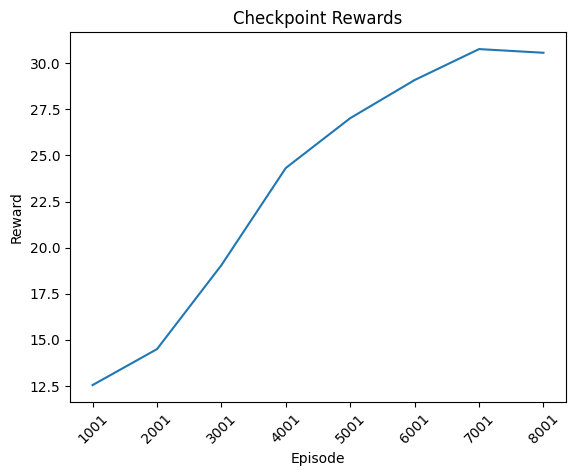

In [105]:
from matplotlib import pyplot as plt

file_path = "./30_rew_checkpoint/checkpoint_rew.json"

with open(file_path, 'r') as file:
    checkpoint_rewards = json.load(file)

# Extract the episode numbers and rewards from the dictionary
episodes = list(checkpoint_rewards.keys())
rewards = list(checkpoint_rewards.values())

# Plot the rewards
plt.plot(episodes, rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Checkpoint Rewards')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()
